# Imports
---

In [1]:
# Imports
import requests
import json
import os
import pandas as pd
import datetime
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates

# Loading Data
---

In [2]:
# Path variables for file access
paths = {}

paths['data'] = './data/youtube'
paths['data-stocks'] = './data/key_stocks'
paths['api'] = './api_tokens.json'

paths

{'data': './data/youtube',
 'data-stocks': './data/key_stocks',
 'api': './api_tokens.json'}

## Pileline for youtube data loading 

In [3]:
# Api variables

api = {}

api['base'] = "https://www.googleapis.com/youtube/v3"

# Pull token from file, not printed here for security reasons
with open( paths['api'] ) as json_file:
    api['token'] = json.load(json_file)['youtube3']

In [4]:
# Utility because some of the data from youtube has a lot of funky characters python doesnt like
def api_parseResponse ( response ) :
    if response.status_code == 200:
        return json.loads(response.text.encode("ascii", "ignore").decode("utf-8"))
    else:
        raise Exception('Token is out of API Requests')

In [5]:
# Search the youtubeAPI for a given channel and get its channelId back

def api_saveChannel ( channel, data ):
    base_path = f"{paths['data']}/{channel}"
    
    if not os.path.exists(base_path): 
        os.mkdir( base_path )
    else:
        print('Channel already has saved folder, assumed finished', end = '\r')
        return
        
    with open(f"{base_path}/_channel.json", 'w') as outfile:
        outfile.write(json.dumps(data))
            
def api_search ( channel, log = False):
    
    response = requests.get( f"{api['base']}/search?part=id%2Csnippet&q={channel}&type=channel&key={api['token']}" )
    response = api_parseResponse( response )
    
    if not response: 
        return
    
    result = response['items'][0]
    api_saveChannel( channel, result )

    if log:
        print(f"Recieved channel info \nname : {result['snippet']['title']} \ndescription : {result['snippet']['description']}")
        print(f"channel_id: {result['id']['channelId']}")
    
    return result['id']['channelId']

In [6]:
# Now lets see if we can search for some good videos!
sample_id = api_search('Stanford', True)

Recieved channel info ved folder, assumed finished
name : Stanford 
description : Located between San Francisco and San Jose in the heart of Silicon Valley, Stanford University is recognized as one of the world's leading research and ...
channel_id: UC-EnprmCZ3OXyAoG7vjVNCA


In [7]:
# Now that we have a channel_id, lets get the vidoes from that channel

def api_saveVideos ( channel ):

    channel_id = api_search( channel )
    
    finished = False
    total = 0
    page_token = ""
    
    base_path = f"{paths['data']}/{channel}"
    
    if ( os.path.exists(f"{base_path}/_videos.txt")):
        print('Channel already has saved videos, assumed finished', end = '\r')
        return
    
    # Limiting to 470 here for various rate limit things about the youtube api
    while not finished and total < 470:

        (videos, totalVideos, finished, page_token) = api_pullPage( channel_id, page_token )

        total += len(videos)
        print(f"Saving batch of {len(videos)} videos, so far {total} of {totalVideos}", end='\r')

        with open(f"{base_path}/_videos.txt", "a") as vidFile:
            vidFile.write( '\n'.join(videos) + '\n' )
            
    print(f"Successfully saved {total} videos from {channel}                                                                  ")


def api_pullPage ( channel_id, page_token ) :

    response = requests.get(f"{api['base']}/search?key={api['token']}&channelId={channel_id}&part=snippet,id&order=date&maxResults=20&pageToken={page_token}")
    response = api_parseResponse( response )
    
    if not response:
        return ([],0,True,'')
    
    video_ids = [ a['id']['videoId'] for a in response['items'] if a['id']['kind'] == 'youtube#video' ]
    total = response['pageInfo']['totalResults']
    next_page = ""
    finished = False
    
    if 'nextPageToken' in response:
        next_page = response['nextPageToken']
    else:
        finished = True

    return (video_ids, total, finished, next_page)

In [8]:
# Testing this, works well at grabbing youtube video ids from channel name
api_saveVideos( 'Stanford' )

In [9]:
# Finaly, getting youtube video metadata from the above video ids

def api_loadVideoMetaData ( channel ):
    
    base_path = f"{paths['data']}/{channel}"
    
    with open(f"{base_path}/_videos.txt", 'r') as vids:
        videos = list(map(lambda v : v[:11], vids.readlines()))
        videos = list(filter(lambda v : len(v) == 11, videos))
        
    if not os.path.exists(f"{base_path}/videos"):
        os.mkdir(f"./data/youtube/{channel}/videos")
    
    for i,vid in enumerate(videos) :
        
        if ( os.path.exists(f"{base_path}/videos/{vid}.txt")):
            print(f"Vid allready processed {i}/{len(videos)}", end='\r')
            continue
            
        response = requests.get(f"{api['base']}/videos?part=snippet,statistics&id={vid}&key={api['token']}")
        response = api_parseResponse( response )
        
        if not response:
            return False
        
        with open (f"{base_path}/videos/{vid}.txt", 'w') as out:
            out.write( json.dumps(response) )
            
        print( f"Saved video {i}/{len(videos)}                                                                  ", end='\r')
        
    print(f"Done with {len(videos)} videos from {channel}                                                                 ", end='\r')

In [10]:
# Testing with stanford Data
api_loadVideoMetaData( 'stanford' )

In [11]:
# Pulling the whole pipeline together
def api_youtubePipeline ( channel ) :
    
    # Search for a channel and save up to the most recent 470 video ids
    api_saveVideos( channel )
    
    # Load all metadata for the requested video ids above
    api_loadVideoMetaData( channel )
    
    print(f"{channel} was successfully processed                                                   ")
    

In [12]:
api_youtubePipeline('Stanford')

Stanford was successfully processed                                                                


## Selecting Channels for Analysis

Since this is ment to be an exploration of youtube videos and the stock market, I have chosen a variety of channels
These choises are likely bias due to the nature of youtube recomendations, but it was the best I could do searching around for a variety of stock-market related content creators.
I have done my best to break down my choices below into a few cataglories to help the analysis, bias as they may be.

### Swingers

These channels are focused on short term gains, following every hot stock and giving predictions on how a single stock will do in the next few days or weeks.
Its likely these channels focus on a small group of stocks each and have high degree of overlap. High risk swing traders, thus the `swingers`

- 40 Finance
- Adriana Gorrin
- Andy's FIRE Club
- Carter Farr
- Financial Health
- George Perez
- Jack Spencer Investing
- Joey Choy
- Market Gains
- Matthew Huo
- StockMoe
- TechConversations
- Tom Nash

### Techies

These chanels are focused on technology and technical indicators. They report changes in prices and trading paterns and algorithms.
Often they promote options or cripto currency aswell. Hence the `techies`

- Altcoin Daily
- DataDash
- Kaswrp
- StockedUp - Mike D'Antonio
- The Kendall Report
- TouchdownTrades
- Trading Fraternity
- True Trading Group
- US vs HERD

### Lifestyle

These channels focus on their own financial journey, their business investments and more conservative personal financial goals.
They are more the personalities behind financial education and promoting people follow their causious footsteps. `Lifestyle` feels like a good label

- Andrei Jikh
- ClearValue Tax 
- GrahamStephan
- Joseph Carlson
- Joseph Carlson Clips
- Meet Kevin
- TaylorBarnes907
- The Money Guy Show

### Mainstream 

Not much needs to be said here. This is the news produced by dirty souless corperations in their quest to subjegate the lowers (too much ? haha )
`Mainstream` is a good label

- Bloomberg Markets and Finance
- CNN Business
- Yahoo Finance

### Talkers

These are non directly stock focused but general news focused personalities. Interesting to include them to see anything interesting going on.
Composed of channels featuring a single main spokesperson talking about the news or other events to the camera.
`Talkers` to represent their content's focus on a single talking lead.

- LastWeekTonight
- PhilipDFranco 
- Real Time with Bill Maher

### Educators

Also included to see how it would work, they are channels focused on various forms of ecconomic education. Not news related at all. 
Could be a good control for seing how other channels are doing. Henseforth the `Educators`

- crash course
- Economics Explained
- The Plain Bagel
- Two Cents

In [13]:
_channels = [
    "40 Finance,Adriana Gorrin,Andy's FIRE Club,Carter Farr,Financial Health,George Perez,Jack Spencer Investing,Joey Choy,Market Gains,Matthew Huo,StockMoe,TechConversations,Tom Nash",
    "Altcoin Daily,DataDash,Kaswrp,StockedUp - Mike D'Antonio,The Kendall Report,TouchdownTrades,Trading Fraternity,True Trading Group,US vs HERD",
    "Andrei Jikh,ClearValue Tax,GrahamStephan,Joseph Carlson,Joseph Carlson Clips,Meet Kevin,TaylorBarnes907,The Money Guy Show",
    "Bloomberg Markets and Finance,CNN Business,Yahoo Finance",
    "LastWeekTonight,PhilipDFranco,Real Time with Bill Maher",
    "crash course,Economics Explained,The Plain Bagel,Two Cents"
]
_labels = [ "Swingers", "Techies", "Lifestyle", "Mainstream", "Talkers", "Educators" ]

In [14]:
# Combination of everything to show what channels with what lables I have chosen
channel_lables = []

for i,label in enumerate(_labels):
    channel_lables.extend([ (c,label) for c in _channels[i].split(',') ])

channel_lables

[('40 Finance', 'Swingers'),
 ('Adriana Gorrin', 'Swingers'),
 ("Andy's FIRE Club", 'Swingers'),
 ('Carter Farr', 'Swingers'),
 ('Financial Health', 'Swingers'),
 ('George Perez', 'Swingers'),
 ('Jack Spencer Investing', 'Swingers'),
 ('Joey Choy', 'Swingers'),
 ('Market Gains', 'Swingers'),
 ('Matthew Huo', 'Swingers'),
 ('StockMoe', 'Swingers'),
 ('TechConversations', 'Swingers'),
 ('Tom Nash', 'Swingers'),
 ('Altcoin Daily', 'Techies'),
 ('DataDash', 'Techies'),
 ('Kaswrp', 'Techies'),
 ("StockedUp - Mike D'Antonio", 'Techies'),
 ('The Kendall Report', 'Techies'),
 ('TouchdownTrades', 'Techies'),
 ('Trading Fraternity', 'Techies'),
 ('True Trading Group', 'Techies'),
 ('US vs HERD', 'Techies'),
 ('Andrei Jikh', 'Lifestyle'),
 ('ClearValue Tax', 'Lifestyle'),
 ('GrahamStephan', 'Lifestyle'),
 ('Joseph Carlson', 'Lifestyle'),
 ('Joseph Carlson Clips', 'Lifestyle'),
 ('Meet Kevin', 'Lifestyle'),
 ('TaylorBarnes907', 'Lifestyle'),
 ('The Money Guy Show', 'Lifestyle'),
 ('Bloomberg Marke

In [15]:
# Lets get the data for them then!
for channel,label in channel_lables:
    api_youtubePipeline ( channel )

40 Finance was successfully processed                                                                
Adriana Gorrin was successfully processed                                                                
Andy's FIRE Club was successfully processed                                                                
Carter Farr was successfully processed                                                                
Financial Health was successfully processed                                                                
George Perez was successfully processed                                                               
Jack Spencer Investing was successfully processed                                                                
Joey Choy was successfully processed                                                                
Market Gains was successfully processed                                                                
Matthew Huo was successfully processed             

## Stock Data Pipeline
For stock data I found an existing dataset that should serve well for this project

Stock Prices [here](https://www.kaggle.com/jacksoncrow/stock-market-dataset)

Has price information for all stocks and etfs for a few decades daily

In [16]:
# Load in a specific etf from the stock dataset
def stocks_loadByTicker ( ticker ):
    data = pd.read_csv ( paths['data-stocks'] + '/' + ticker + '.csv' )
    data['Date'] = pd.to_datetime(data['Date'])
    return data

In [17]:
# Load a stock as a test to show what kind of information is available
stocks_loadByTicker('spy').head()

,Date,Close/Last,Volume,Open,High,Low
0,2020-12-02,366.79,45927000,364.82,366.96,364.20
1,2020-12-01,366.02,74504970,365.57,367.68,364.93
2,2020-11-30,362.06,83872710,362.83,363.12,359.17
3,2020-11-27,363.67,28514070,363.84,364.18,362.58
4,2020-11-25,362.66,45330890,363.13,363.16,361.48


# Data Processing
---

The data from both sources is very raw, this step will help combine everything into cleaner data for analysis

In [18]:
# Get what is needed from a single block of youtube data

def pullValue ( data, value, default ):
    return data[value] if value in data else default

def processing_cleanRawVideo ( videoData ):
    response = {}
    videoData =  videoData['items'][0]
    
    response['id'] = videoData['id']
    response['date'] = videoData['snippet']['publishedAt'][:10]
    response['title'] = videoData['snippet']['title']
    response['description'] = videoData['snippet']['description']
    response['channelTitle'] = videoData['snippet']['channelTitle']
    response['tags'] = pullValue( videoData['snippet'], 'tags', ['untagged'])
    response['views'] = pullValue( videoData['statistics'], 'viewCount', 0) 
    response['likes'] = pullValue( videoData['statistics'], 'likeCount', 0)
    response['dislikes'] =  pullValue( videoData['statistics'], 'dislikeCount', 0)
    response['commentCount'] = pullValue( videoData['statistics'], 'commentCount', 0)
    
    return response

In [19]:
# Lets see what data we have, printing out a sample block of video metadata from saved data

# Get the first video of the first channel
_data_path = f"{paths['data']}/{channel_lables[0][0]}/videos"
_data_videos = os.listdir( _data_path )

# Load its data as json
with open( f"{_data_path}/{_data_videos[0]}", 'r') as f:
    _data = json.load(f)
    
# Send it to preproccessing function
_sample_video = processing_cleanRawVideo(_data)

# Visualize the data we have gotten
pd.DataFrame(_sample_video).head()

,id,date,title,description,channelTitle,tags,views,likes,dislikes,commentCount
0,-bIWAEn2JD8,2020-11-01,5 Wall Street Bets for 2021 | Stock Market Pre...,If you are familiar with the famous wallstreet...,40 Finance,stock market,2161,101,2,25
1,-bIWAEn2JD8,2020-11-01,5 Wall Street Bets for 2021 | Stock Market Pre...,If you are familiar with the famous wallstreet...,40 Finance,stock analysis,2161,101,2,25
2,-bIWAEn2JD8,2020-11-01,5 Wall Street Bets for 2021 | Stock Market Pre...,If you are familiar with the famous wallstreet...,40 Finance,investing,2161,101,2,25
3,-bIWAEn2JD8,2020-11-01,5 Wall Street Bets for 2021 | Stock Market Pre...,If you are familiar with the famous wallstreet...,40 Finance,wallstreetbets,2161,101,2,25
4,-bIWAEn2JD8,2020-11-01,5 Wall Street Bets for 2021 | Stock Market Pre...,If you are familiar with the famous wallstreet...,40 Finance,wall street bets,2161,101,2,25


In [20]:
# This data is not formatted well, cleaning it up here by parsing it into multiple different parts
# Returns tupple represneting video data and list of tags
def processing_cleanVideo ( videoData ):
    
    raw = processing_cleanRawVideo( videoData )
    video_meta = pd.DataFrame(raw)
    tags = video_meta['tags']
    video_meta['date'] = pd.to_datetime( video_meta['date'] )
    video_meta = video_meta.drop('tags', axis = 1)

    video_tags = [ (video_meta['id'].loc[0],tag) for tag in tags ]
    
    return (video_meta.loc[0], video_tags)
    

In [21]:
# Run this processing for every channel we have

output = ''

for channel,label in channel_lables:

    print('Processing', channel, end='\r')

    # Load list of all videos
    base_path = f"{paths['data']}/{channel}/videos"
    channel_videos = os.listdir( base_path )
    
    if os.path.exists(f"{paths['data']}/{channel}/_rows.csv"):
        continue
    
    # Put data into memory
    rows = []
    tags = []
    
    # Load all the files
    for vid in channel_videos:
        
        with open( f"{base_path}/{vid}", 'r') as f:
            _data = json.load(f)
            
        (_rows,_tags) = processing_cleanVideo( _data )
        _rows['label'] = label
        rows.append( _rows )
        tags.extend( _tags )
        
    # Process into combined dataframes
    rows = pd.DataFrame ( rows )
    rows = rows.set_index('id')
    rows.to_csv(f"{paths['data']}/{channel}/_rows.csv")
    
    tags = pd.DataFrame ( tags, columns=['id', 'tag'])
    tags.to_csv(f"{paths['data']}/{channel}/_tags.csv", index=False)
    
    print('Finished Processing', channel, end ='\r')
print('Done with all of the channels!', len(channel_lables), 'total.')

Done with all of the channels! 40 total.


## Data Visualization
---
We have all our data from the sources and it is saved in usable formats, lets see what we have!

### Publication Dates

In [22]:
# First, all our videos are published at differeent times, lets see if we can see what we got
viz_channels = []
for (channel,_) in channel_lables:
    path = f"{paths['data']}/{channel}"
    videos = pd.read_csv(f"{path}/_rows.csv").set_index('id')
    videos['date'] = pd.to_datetime(videos['date'])
    first = videos['date'].min()
    last = videos['date'].max()
    name = videos.iloc[0]['channelTitle']
    viz_channels.append((name,first,last))

viz_channels = pd.DataFrame(viz_channels, columns=['channel', 'first', 'last']).sort_values(by='first', ascending=False)
viz_channels.head()

,channel,first,last
32,Yahoo Finance,2020-11-03,2020-12-02
29,The Money Guy Show,2020-10-04,2020-12-01
11,TechConversations,2020-09-02,2020-12-01
4,Financial Health,2020-08-23,2020-12-01
10,Stock Moe,2020-08-17,2020-12-01


Text(0.5, 0, 'First and last video for each source')

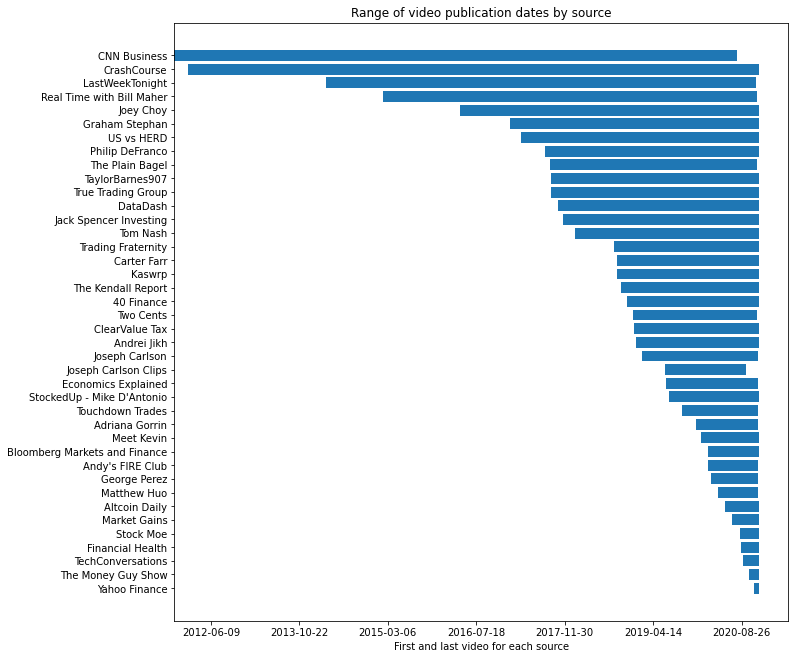

In [23]:
# Clearly we have a range of publication dates from all of our sources
# Publication dates are all over the place because of the variety of sources pulled and the limit on video counts.
# Since videos were pulled from newest to oldest, we have a lot of recent data that peters off over time
fig, ax = plt.subplots()
plt.barh(viz_channels['channel'], width=(viz_channels['last']-viz_channels['first']), left=viz_channels['first'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.set_size_inches(11,11)
plt.title('Range of video publication dates by source')
plt.xlabel('First and last video for each source')

### Tag usage

In [24]:
# First exploring what tags we have overall
columns = []
for (channel,_) in channel_lables:
    path = f"{paths['data']}/{channel}"
    tags = pd.read_csv(f"{path}/_tags.csv").set_index('id')
    videos = pd.read_csv(f"{path}/_rows.csv").set_index('id')
    merged = tags.join(videos)
    merged = merged[['tag','date']].reset_index().drop(columns=['id'])
    columns.append( merged )

In [25]:
# Concat to see all tags by date across all the channels
viz_tagByDate = pd.concat( columns )
viz_tagByDate['clean_tag'] = viz_tagByDate['tag'].str.replace(r'[^A-Za-z]', '')
viz_tagByDate['clean_tag'] = viz_tagByDate['clean_tag'].str.lower()

viz_rankedTags = viz_tagByDate.groupby(['clean_tag']).size().reset_index().sort_values(by=[0], ascending=False)
viz_tagByDate = viz_tagByDate.groupby(['clean_tag', 'date']).size().reset_index()
viz_tagsByDate = viz_tagByDate.groupby(['date']).size().reset_index().set_index('date')

# Lets see the most common tags, no surprise there
viz_rankedTags[:10]

,clean_tag,0
28767,stockmarket,3569
29106,stocks,3342
15840,investing,2692
21643,news,1759
29224,stockstobuy,1548
20677,money,1389
32348,topstocks,1198
29256,stockstobuynow,1192
29372,stocktrading,1181
23144,passiveincome,1156


In [26]:
# Utility function to get the reletive occurance of a given tag over time
def viz_tagOverTime ( tag ):
    dates = viz_tagByDate[ viz_tagByDate['clean_tag'] == tag ].set_index('date')
    
    delta = datetime.timedelta(days=1)
    first = datetime.datetime.strptime(dates.index.min(), '%Y-%m-%d')
    last = datetime.datetime.strptime(dates.index.max(), '%Y-%m-%d')
    
    ratios = []
    
    while first <= last:
        _date = first.strftime("%Y-%m-%d")
        first += delta
        
        if _date in dates.index:
            ratios.append (( dates.loc[_date][0],
                             viz_tagsByDate.loc[_date][0],
                             _date ))
        else:
            ratios.append((0,0,_date))
    
    return pd.DataFrame(ratios, columns=['count','total','date'])

In [27]:
def dual_rolling_smooth ( data, d = 5 ):
    return pd.Series(data).rolling(d).mean()[::-1].rolling(d).mean()[::-1] 

In [28]:
# Taking in the trend data and scaling it relative to other tags over time
# Plus, adding a rolling average to smooth some of the stuttering
def viz_processesTagOverTime ( tag ):
    performance = viz_tagOverTime( tag )
    performance['ratio'] = (performance['count']/performance['total']).fillna(0)
    performance['trend'] = dual_rolling_smooth( performance['ratio'], d = 5 )
    performance['trend2'] = dual_rolling_smooth( performance['ratio'], d = 20 )
    performance['date'] = pd.to_datetime(performance['date'])
    performance = performance.sort_values(by='date')
    return performance

In [29]:
def viz_scaleColumn ( data, col ):
    data[col] = (data[col] - data[col].min())/(data[col].max()-data[col].min())

In [61]:
def viz_coorilation ( tag, ticker, plot, cuttoff = '2017-01-01' ):
    
    # Cleaning data
    performance = viz_processesTagOverTime( tag )
    market = stocks_loadByTicker(ticker)

    market = market[ market['Date'] > cuttoff]
    performance = performance[ performance['date'] > cuttoff ]

    viz_scaleColumn(performance, 'trend')
    viz_scaleColumn(performance, 'trend2')
    viz_scaleColumn(market, ' Open')
    market['Open1']=dual_rolling_smooth(market[' Open'], d=5)
    market['Open2']=dual_rolling_smooth(market[' Open'], d=10)
    
    # Plot it out
    #ax1.plot(performance['date'], performance['trend'], label="youtube")
    #ax1.plot(market['Date'], market['Open1'], label='market')
    #ax1.set(xlabel='Date', ylabel='Youtube Tags & Stock Prices')
    #ax1.set_title('Price and Tag relative performance')

    plot.plot(performance['date'], performance['trend2'], label=(tag +" (youtube)"))
    plot.plot(market['Date'], market['Open2'], label=(ticker +" (stock)"))
    plot.set(xlabel='Date', ylabel='Youtube Tags & Stock Prices (smoothed)')
    plot.set_title(F"'{tag}' vs '{ticker}' relative performance")
    plot.legend()


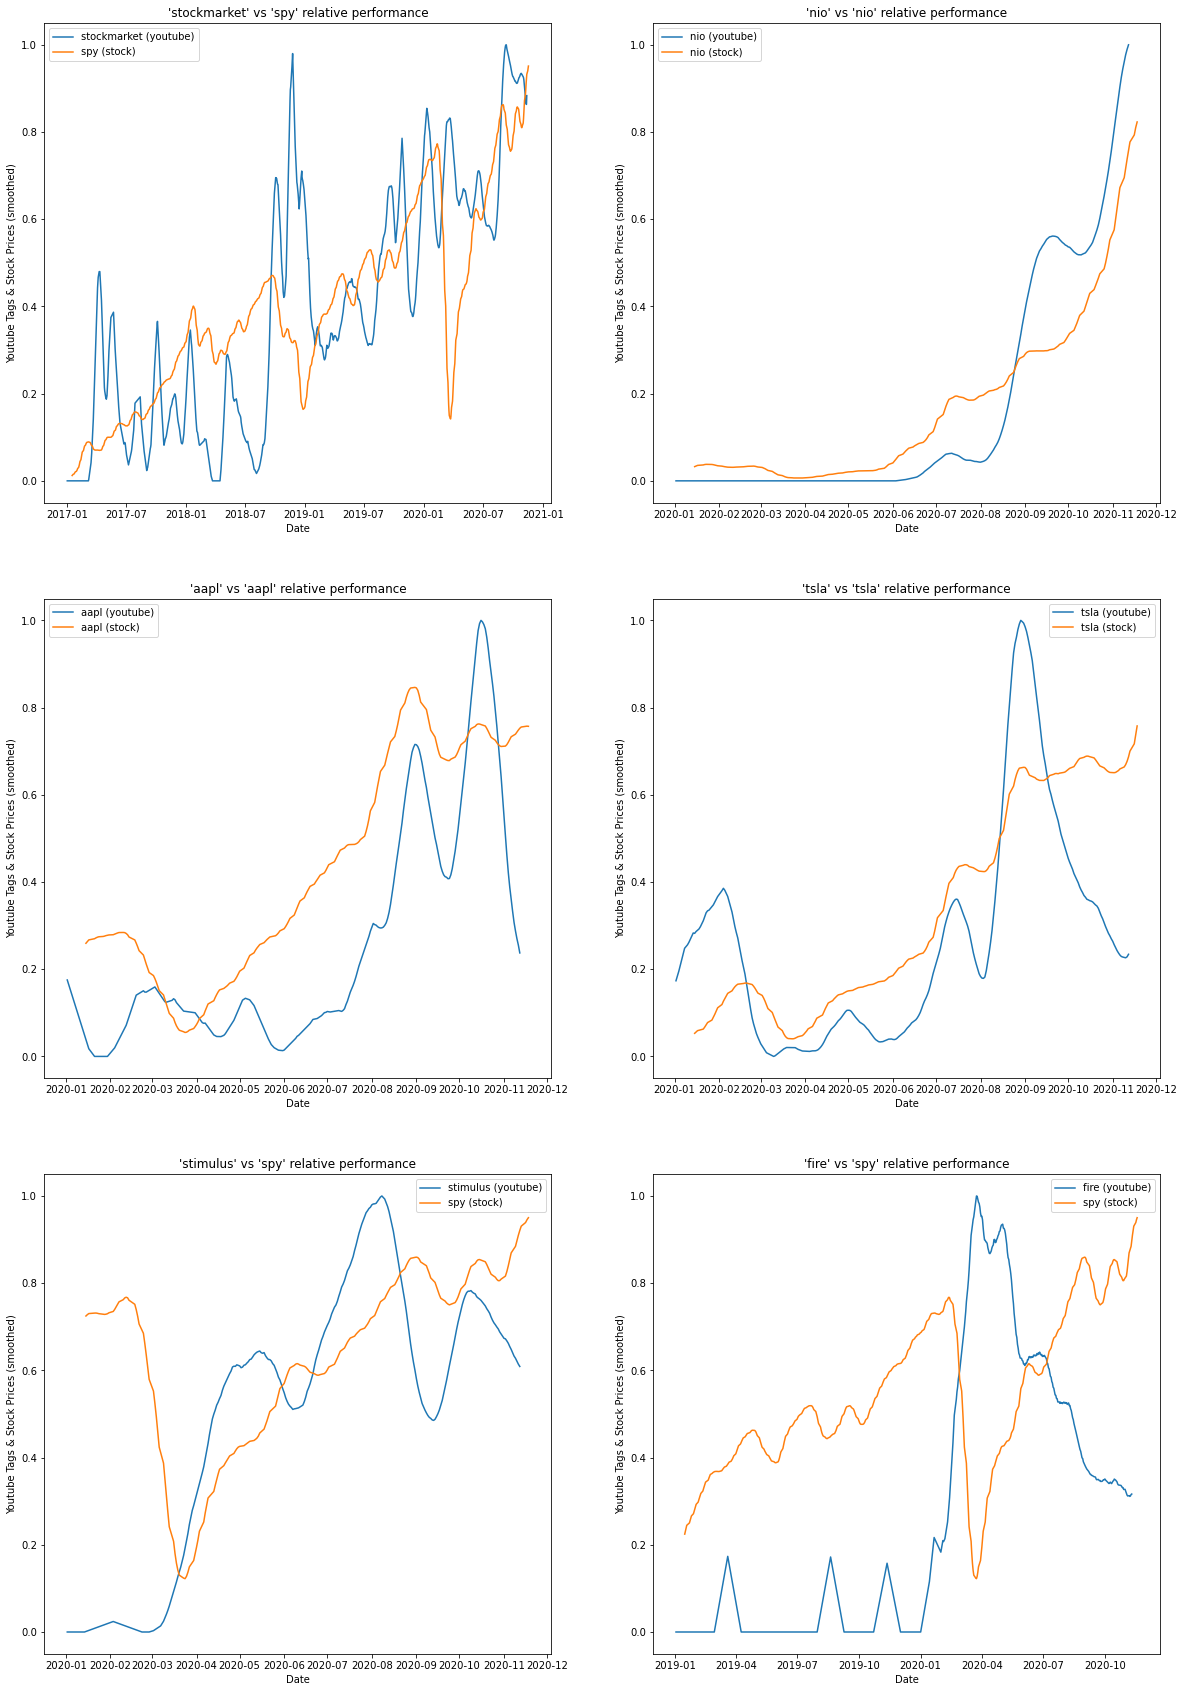

In [62]:
# Lets graph some coorilations
viz_coorilations = [
    ('stockmarket', 'spy', '2017-01-01'),
    ('nio', 'nio', '2020-01-01'),
    ('aapl', 'aapl', '2020-01-01'),
    ('tsla', 'tsla', '2020-01-01'),
    ('stimulus', 'spy', '2020-01-01'),
    ('fire', 'spy', '2019-01-01')
]

fig, axs = plt.subplots(3,2)

for i,a in enumerate(axs.flatten()):
    (tag,ticker,cuttoff) = viz_coorilations[i]
    viz_coorilation(tag, ticker, a, cuttoff=cuttoff)
    
fig.set_size_inches(20,30)

Note how the dateset is mostly recent data, so there is very little data for time before 2017. Regardless, this chart shows some sort of relative interest in the stock market over time. An important feature is that right as the market crashed in 2019, video content exploded, falling down again as the market recovered.

This one is a clearer one wow, youtube interest is clearly seen to be skyrocketing with the stock price.

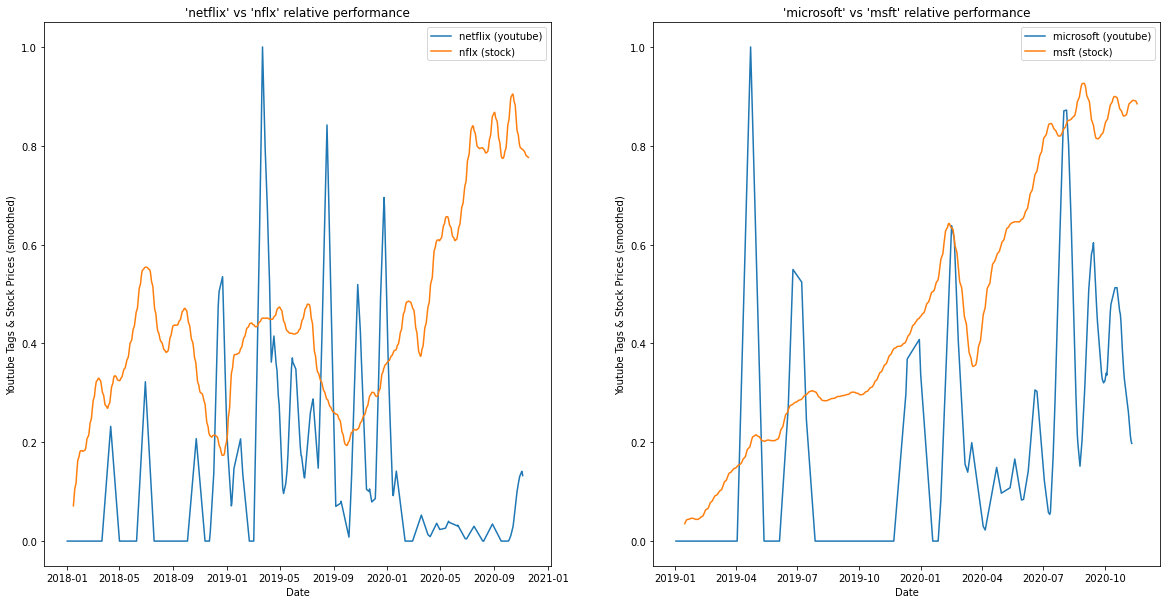

In [63]:
viz_coorilations = [
    ('netflix', 'nflx', '2018-01-01'),
    ('microsoft', 'msft', '2019-01-01')
]

fig, axs = plt.subplots(1,2)

for i,a in enumerate(axs.flatten()):
    (tag,ticker,cuttoff) = viz_coorilations[i]
    viz_coorilation(tag, ticker, a, cuttoff=cuttoff)
    
fig.set_size_inches(20,10)

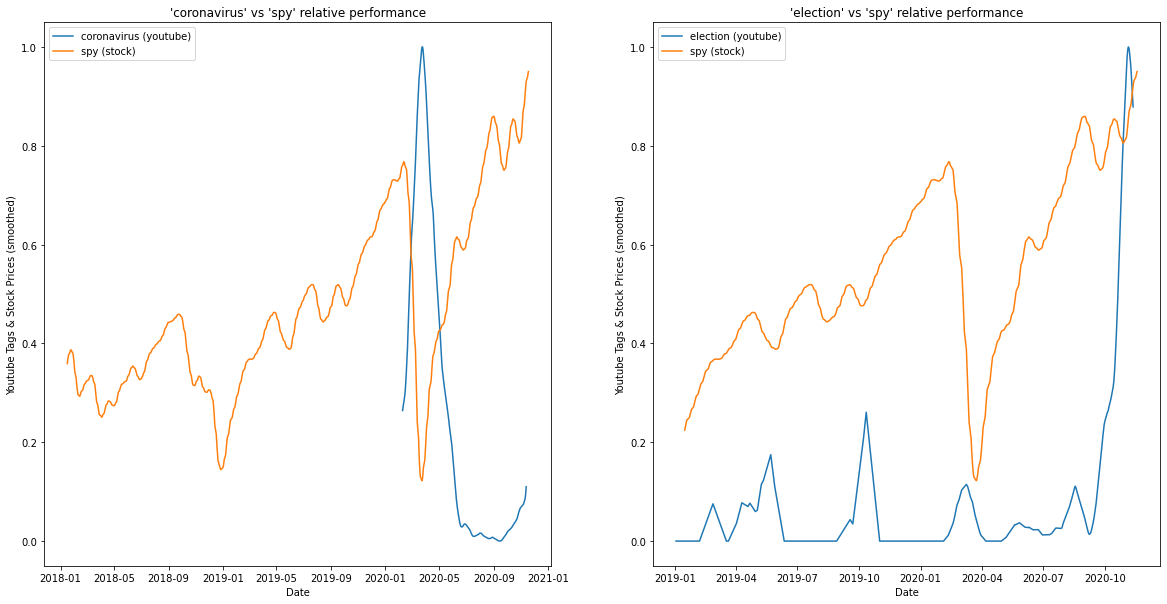

In [64]:
viz_coorilations = [
    ('coronavirus', 'spy', '2018-01-01'),
    ('election', 'spy', '2019-01-01')
]

fig, axs = plt.subplots(1,2)

for i,a in enumerate(axs.flatten()):
    (tag,ticker,cuttoff) = viz_coorilations[i]
    viz_coorilation(tag, ticker, a, cuttoff=cuttoff)
    
fig.set_size_inches(20,10)

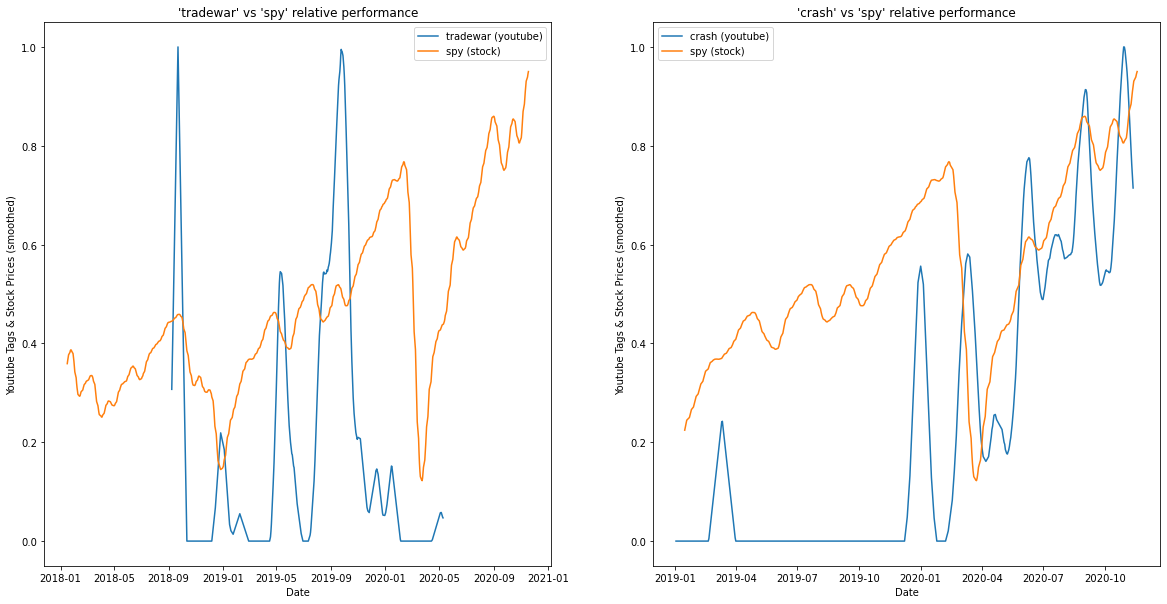

In [65]:
viz_coorilations = [
    ('tradewar', 'spy', '2018-01-01'),
    ('crash', 'spy', '2019-01-01')
]

fig, axs = plt.subplots(1,2)

for i,a in enumerate(axs.flatten()):
    (tag,ticker,cuttoff) = viz_coorilations[i]
    viz_coorilation(tag, ticker, a, cuttoff=cuttoff)
    
fig.set_size_inches(20,10)

# Sentiment over time 


In [66]:
import math

In [67]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\Eric
[nltk_data]     Robertson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
# Exploring the sentiment of each video
columns = []
for (channel,_) in channel_lables:
    path = f"{paths['data']}/{channel}"
    tags = pd.read_csv(f"{path}/_tags.csv").set_index('id')
    videos = pd.read_csv(f"{path}/_rows.csv").set_index('id')
    merged = tags.join(videos)
    merged = merged[['tag','date','title', 'description']].reset_index().drop(columns=['id'])
    columns.append( merged )

In [69]:
sent_data = pd.concat(columns)
pd.unique(sent_data['title'])

array(['Microsoft Stock Price Prediction 2022 | MSFT Stock Analysis',
       '5 Wall Street Bets for 2021 | Stock Market Predictions',
       'Universal Display (OLED) Stock Analysis', ...,
       'Do You Really Want to Be Your Own Boss?',
       "What's the Best Way to Support Musicians?",
       'How Do You Actually Buy a House?'], dtype=object)

In [70]:
sent_map = {}
for item in pd.unique(sent_data['title']):
    if item in sent_map:
        continue
    sent_map[item] = sid.polarity_scores(item)['compound']
for item in pd.unique(sent_data['description']):
    if item in sent_map:
        continue
    if not isinstance(item, str):
        sent_map[item] = 0
        continue
    sent_map[item] = sid.polarity_scores(item)['compound']

In [71]:
sent_data['title_sent'] = pd.DataFrame( sent_data['title'].map( sent_map ))
sent_data['desc_sent'] = pd.DataFrame( sent_data['description'].map( sent_map ))
sent_data

,tag,date,title,description,title_sent,desc_sent
0,stock market,2020-08-27,Microsoft Stock Price Prediction 2022 | MSFT S...,Microsoft stock has been a consistent winner i...,0.0,0.8649
1,stock analysis,2020-08-27,Microsoft Stock Price Prediction 2022 | MSFT S...,Microsoft stock has been a consistent winner i...,0.0,0.8649
2,investing,2020-08-27,Microsoft Stock Price Prediction 2022 | MSFT S...,Microsoft stock has been a consistent winner i...,0.0,0.8649
3,Microsoft stock,2020-08-27,Microsoft Stock Price Prediction 2022 | MSFT S...,Microsoft stock has been a consistent winner i...,0.0,0.8649
4,MSFT stock,2020-08-27,Microsoft Stock Price Prediction 2022 | MSFT S...,Microsoft stock has been a consistent winner i...,0.0,0.8649
...,...,...,...,...,...,...
1033,how to buy house,2019-05-22,How Do You Actually Buy a House?,Think you're ready to buy a house? The path to...,0.0,0.9642
1034,buy house,2019-05-22,How Do You Actually Buy a House?,Think you're ready to buy a house? The path to...,0.0,0.9642
1035,when to buy a house,2019-05-22,How Do You Actually Buy a House?,Think you're ready to buy a house? The path to...,0.0,0.9642
1036,how to own a house,2019-05-22,How Do You Actually Buy a House?,Think you're ready to buy a house? The path to...,0.0,0.9642


In [54]:
sent_data['clean_tag'] = sent_data['tag'].str.replace(r'[^A-Za-z]', '')
sent_data['clean_tag'] = sent_data['clean_tag'].str.lower()

sent_data_byTag = sent_data.groupby(['clean_tag']).mean().reset_index()
sent_data_byTagDate = sent_data.groupby(['clean_tag', 'date']).mean().reset_index()
sent_data_byDate = sent_data.groupby(['date']).mean().reset_index().set_index('date')

sent_data_byTagDate

,clean_tag,date,title_sent,desc_sent
0,,2012-02-23,-0.4019,0.9147
1,,2012-08-28,0.0000,0.0000
2,,2012-09-20,-0.4019,0.8297
3,,2013-03-21,-0.4019,0.9184
4,,2013-04-11,-0.4019,0.9844
...,...,...,...,...
155782,zygote,2015-11-23,-0.4019,0.9626
155783,zyklonb,2020-04-10,-0.8126,-0.9801
155784,zyngastock,2019-05-05,0.0000,0.9670
155785,zyngastock,2020-03-28,0.0000,0.9224


In [55]:
def sent_compile ( tag ):
    dates = sent_data_byTagDate[ sent_data_byTagDate['clean_tag'] == tag ]
    dates['date'] = pd.to_datetime(dates['date'])
    dates = dates.set_index('date')
    delta = datetime.timedelta(days=1)
    first = dates.index.min()
    last = dates.index.max()
    
    ratios = []
    
    while first <= last:
        if first in dates.index:
            row = dates.loc[first]
            ratios.append (( first, row['title_sent'], row['desc_sent']))
        else:
            ratios.append(( first, 0, 0 ))
        first += delta
    
    return pd.DataFrame( ratios, columns=['date', 'title', 'desc'])
    
    

In [77]:
def sent_chart ( tag, ticker, plots, cuttoff = '2019-01-01' ):
    performance = sent_compile( tag )
    market = stocks_loadByTicker(ticker)

    market = market[ market['Date'] > cuttoff]
    performance = performance[ performance['date'] > datetime.datetime.strptime(cuttoff, '%Y-%m-%d') ]

    performance['title']=dual_rolling_smooth(performance['title'], d=20)
    performance['desc']=dual_rolling_smooth(performance['desc'], d=20)

    viz_scaleColumn(performance, 'title')
    viz_scaleColumn(performance, 'desc')
    viz_scaleColumn(market, ' Open')
    market['Open1']=dual_rolling_smooth(market[' Open'], d=5)
    market['Open2']=dual_rolling_smooth(market[' Open'], d=10)

    plots[0].plot(performance['date'], performance['title'], label=(tag +" (youtube)"))
    plots[0].plot(market['Date'], market['Open2'], label=(ticker +" (stock)"))
    plots[0].set(xlabel='Date', ylabel='Youtube Tags & Stock Prices (smoothed)')
    plots[0].set_title(F"'{tag}' titles vs '{ticker}' relative performance")
    plots[0].legend()
    
    plots[1].plot(performance['date'], performance['desc'], label=(tag +" (youtube)"))
    plots[1].plot(market['Date'], market['Open2'], label=(ticker +" (stock)"))
    plots[1].set(xlabel='Date', ylabel='Youtube Tags & Stock Prices (smoothed)')
    plots[1].set_title(F"'{tag}' descriptions vs '{ticker}' relative performance")
    plots[1].legend()
    

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel

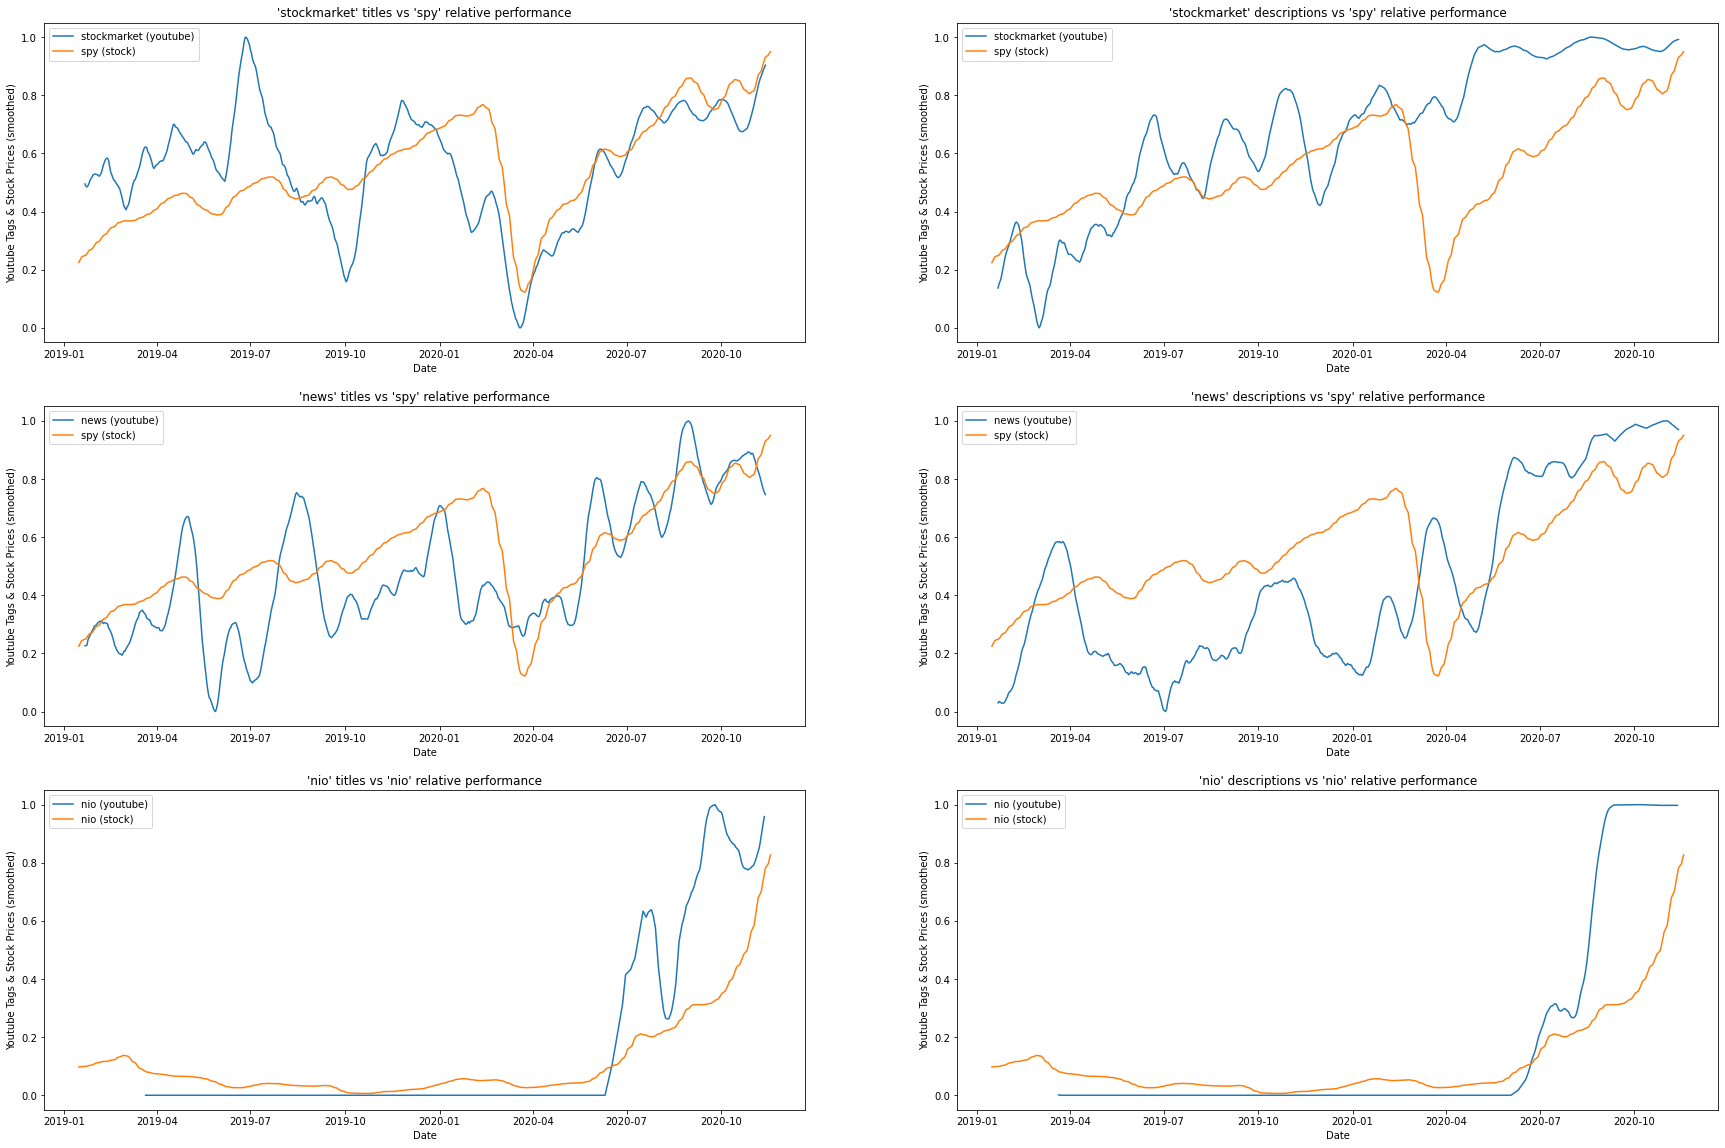

In [169]:
fig, axs = plt.subplots(3,2)

sent_chart( 'stockmarket', 'spy', axs[0] )
sent_chart( 'news', 'spy', axs[1] )
sent_chart( 'nio', 'nio', axs[2] )

fig.set_size_inches(30,20)

In [171]:
# Lets come up with a basic score that can help evaluate the models
def matching_score ( tag, ticker, plot, cuttoff = '2019-01-01' ):
    performance = sent_compile( tag )
    market = stocks_loadByTicker(ticker)

    market = market[ market['Date'] > cuttoff]
    market['date'] = market['Date']
    performance = performance[ performance['date'] > datetime.datetime.strptime(cuttoff, '%Y-%m-%d') ]

    performance['title']=dual_rolling_smooth(performance['title'], d=20)
    performance['desc']=dual_rolling_smooth(performance['desc'], d=20)

    viz_scaleColumn(performance, 'title')
    viz_scaleColumn(performance, 'desc')
    viz_scaleColumn(market, ' Open')
    market['Open1']=dual_rolling_smooth(market[' Open'], d=20)
    market['Open2']=dual_rolling_smooth(market[' Open'], d=10)

    market['gains_market'] = market['Open1'].diff()
    performance['gains_sent'] = performance['title'].diff()
    
    market = market.set_index('date')
    performance = performance.set_index('date')
    
    combined = pd.concat([market,performance],  axis=1, join='inner').dropna().sort_index()
    
    combined['score'] = combined['gains_market'] * combined['gains_sent']
    combined['score_pos'] = combined['gains_market'] * (combined['gains_sent'] > 0).astype(int)
    
    combined['running_all'] = combined['score'].cumsum()
    combined['running_pos'] = combined['score_pos'].cumsum()
    
    plot.plot(combined.index, combined['running_all'])
    plot.plot(combined.index, combined['running_pos'])

    return combined

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


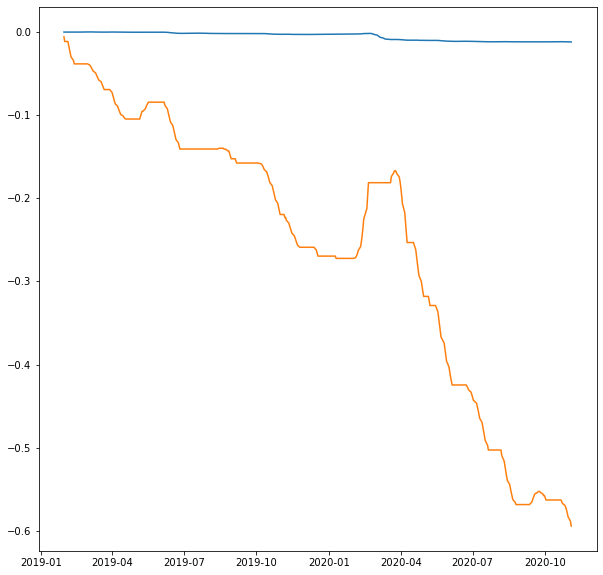

In [172]:
fig, axs = plt.subplots(1,1)
a = matching_score( 'stockmarket', 'spy', axs )
fig.set_size_inches(10,10)

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


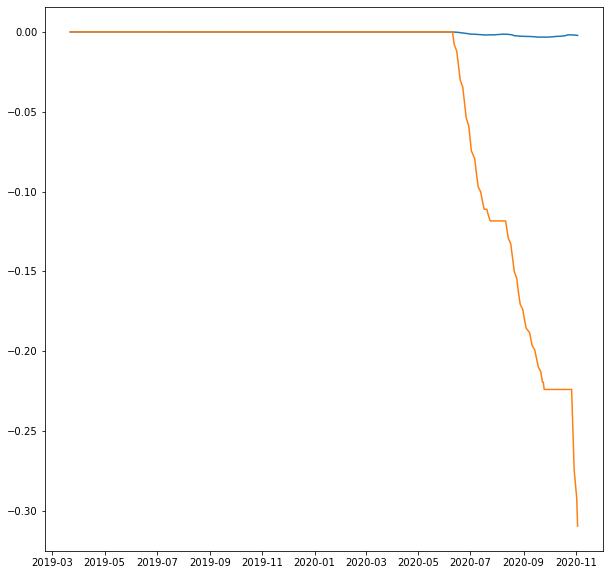

In [173]:
fig, axs = plt.subplots(1,1)
a = matching_score( 'nio', 'nio', axs )
fig.set_size_inches(10,10)